# Read SUMMA output

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper')
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

## Functions to quickly evaluate all model output

In [3]:
def sortFun(s):
    if 'high' in s and 'L' in s:
        return(4)
    elif 'high' in s and 'S' in s:
        return(3)
    elif 'low' in s and 'S' in s:
        return(2)
    elif 'low' in s and 'L' in s:
        return(1)

In [7]:
def snowPresence(ds, obs):
    snowPresenceArray = (obs.SP == 1) & (ds['scalarSWE'] > 0) & (ds['scalarSurfaceTemp'] < 273.2)
    return(snowPresenceArray)

def createSnowSurfTemp(ds):
    snowTempArray = ds['scalarSurfaceTemp'].where((ds['scalarSWE'] > 0) & (ds['scalarSurfaceTemp'] < 273.2))
    return(snowTempArray)

def water_year(time_index, last_month=9):
    year = time_index.to_index().year
    year[time_index.to_index().month > last_month] += 1 
    return xr.DataArray(year, dims=time_index.dims, coords=time_index.coords, name='water_year')

## Forcing data

In [5]:
# ----------
# Sites and forcing data
siteNames = ['SWA', 'CDP']
siteYears = {'SWA': np.arange(2006, 2012),
             'CDP': np.arange(2002, 2010)}

d1 = {'CDP': datetime(2002, 10, 1), 'SWA': datetime(2006, 10, 1)}
d2 = {'CDP': datetime(2010, 9, 30, 22, 0, 0), 'SWA': datetime(2012, 9, 30, 23, 0, 0)}

os.chdir(dirData)
CDPforce = xr.open_dataset('CDP.ModTsfc.nc')
CDPforce = CDPforce.loc[dict(time = slice(d1['CDP'], d2['CDP']))]
CDPforce_daily = CDPforce.resample(how='mean', freq='d', dim='time')

SWAforce = xr.open_dataset('SWA.ModTsfc.nc')
SWAforce = SWAforce.loc[dict(time = slice(d1['SWA'], d2['SWA']))]
SWAforce_daily = SWAforce.resample(how='mean', freq='d', dim='time')

# ----------
# Summa modeling results for each site
os.chdir(dirData  + '/summaResults')

SWA = xr.open_dataset('SWA.summaResults.forcing.nc')
SWA = xr.concat([SWA, xr.open_dataset('SWA.summaResults.internal.nc')], 'expID')

CDP = xr.open_dataset('CDP.summaResults.forcing.nc')
CDP = xr.concat([CDP, xr.open_dataset('CDP.summaResults.internal.nc')], 'expID')

# ----------
# snow surface temperature and snow presence
SWA['SP'] = snowPresence(SWA, SWAforce)
SWA['scalarSnowTemp'] = createSnowSurfTemp(SWA)
CDP['SP'] = snowPresence(CDP, CDPforce)
CDP['scalarSnowTemp'] = createSnowSurfTemp(CDP)

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


In [6]:
# ----------
# Experiment names - Structure Uncertainty
experiments = ['longwaveBias', 'shortwaveBias', 'specHumidBias',
               'airTempBias', 'windBias', 'layers',
               'thermalCond', 'stability']
expMetUnc = ['longwaveBias', 'shortwaveBias', 'specHumidBias',
               'airTempBias', 'windBias']
expIntern = ['layers', 'thermalCond', 'stability']
experimentType = {'forcing': expMetUnc, 'internal': expIntern}
force = {'SWA': SWAforce, 'CDP': CDPforce}
results = {'SWA': SWA, 'CDP': CDP}

# Met uncertainty experiment IDs and values
expNames = {'longwaveBias': ['lowLW_L','lowLW_S', 'highLW_S', 'highLW_L']}
expBias = {'longwaveBias': {'lowLW_L': -25, 'lowLW_S': -10, 'highLW_S': 10, 'highLW_L': 25}}
expBiasLabels = {'longwaveBias': ['-25 $Wm^{-2}$', '-10 $Wm^{-2}$', '+10 $Wm^{-2}$', '+25 $Wm^{-2}$']}

expNames['shortwaveBias'] = ['lowSW_L','lowSW_S', 'highSW_S', 'highSW_L']
expBias['shortwaveBias'] = {'lowSW_L': -80, 'lowSW_S': -30, 'highSW_S': 30, 'highSW_L': 80}
expBiasLabels['shortwaveBias'] = ['-80 $Wm^{-2}$', '-30 $Wm^{-2}$', '+30 $Wm^{-2}$', '+80 $Wm^{-2}$']

expNames['specHumidBias'] = ['lowQS_L','lowQS_S', 'highQS_S', 'highQS_L']
expBias['specHumidBias'] = {'lowQS_L': -25,  'lowQS_S': -10, 'highQS_S': 10, 'highQS_L': 25}
expBiasLabels['specHumidBias'] = ['-25%', '-10%', '+10%', '+25%']

expNames['airTempBias'] = ['lowTair_L','lowTair_S', 'highTair_S', 'highTair_L']
expBias['airTempBias'] = {'lowTair_L': -3, 'lowTair_S': -1.5, 'highTair_S': 1.5, 'highTair_L': 3}
expBiasLabels['airTempBias'] = ['-3$^{\circ}$C', '-1.5$^{\circ}$C', '+1.5$^{\circ}$C', '+3$^{\circ}$C']

expNames['windBias'] = ['lowU_L','lowU_S', 'highU_S', 'highU_L']
expBias['windBias'] = {'lowU_L': -3, 'lowU_S': -1.5, 'highU_S': 1.5, 'highU_L': 3}
expBiasLabels['windBias'] = ['-3$ms^{-1}$', '-1.5$ms^{-1}$', '+1.5$ms^{-1}$', '+3$ms^{-1}$']

metName = {'longwaveBias': 'LWRadAtm',
           'shortwaveBias': 'SWRadAtm',
           'specHumidBias': 'spechum',
           'airTempBias': 'airtemp',
           'windBias': 'windspd'}

metNameTitle = {'longwaveBias': 'Longwave Bias (Wm$^{-2}$)',
           'shortwaveBias': 'Shortwave Bias (Wm$^{-2}$)',
           'specHumidBias': 'Relative Humiditiy Bias (%)',
           'airTempBias': 'Air Temperature Bias ($^{\circ}$C)',
           'windBias': 'Wind Speed Bias (m s$^{-1}$)'}

# Layer
expNames['layers'] = ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010']

# Thermal conductivity
arrayNames = ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']
arrayAppend = ['Mid', 'Low', 'High']
expNames['thermalCond'] = [name + '_' + append for name in arrayNames for append in arrayAppend]

# Stability
arrayAppend = ['Low', 'Mid', 'High']
arrayNames = ['standard', 'louisinv', 'mahrtexp']
expNames['stability'] = [name + '_' + append for name in arrayNames for append in arrayAppend]

internalNames = {'stability': ['standard', 'louisinv', 'mahrtexp'],
                 'layers': ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010'],
                 'thermalCond': ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']}

# ----------
# Scalar variables to extract from output
scalar_data_vars = ['scalarRainPlusMelt', 'scalarSWE', 'scalarSnowSublimation', 
                    'scalarInfiltration', 'scalarSurfaceRunoff', 'scalarSurfaceTemp',
                    'scalarSenHeatTotal', 'scalarLatHeatTotal', 'scalarSnowDepth']

In [52]:
CDPforce_monthly = CDPforce_daily.resample(how='mean', dim='time', freq='M')
CDPforce_monthly['precipSnow'] = CDPforce.precipSnow.resample(how='sum', dim='time', freq='M') / 1000 * 3600

SWAforce_monthly = SWAforce_daily.resample(how='mean', dim='time', freq='M')
SWAforce_monthly['precipSnow'] = SWAforce.precipSnow.resample(how='sum', dim='time', freq='M') / 1000 * 3600

# Require at least 10 days of snow presence to count a month
CDPforce_monthly = CDPforce_monthly.where(CDPforce_monthly.SP > 0.3)
SWAforce_monthly = SWAforce_monthly.where(SWAforce_monthly.SP > 0.3)

force_monthly = {'SWA': SWAforce_monthly, 'CDP': CDPforce_monthly}

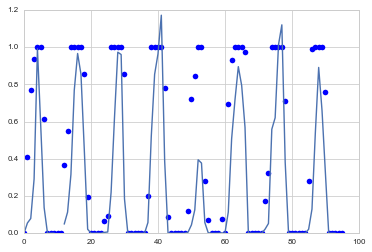

In [28]:
# plt.plot(CDPforce.precipSnow, 'r')
plt.plot(CDPforce_monthly.SP, 'ob')
plt.plot(CDPforce_monthly.snowDepth)

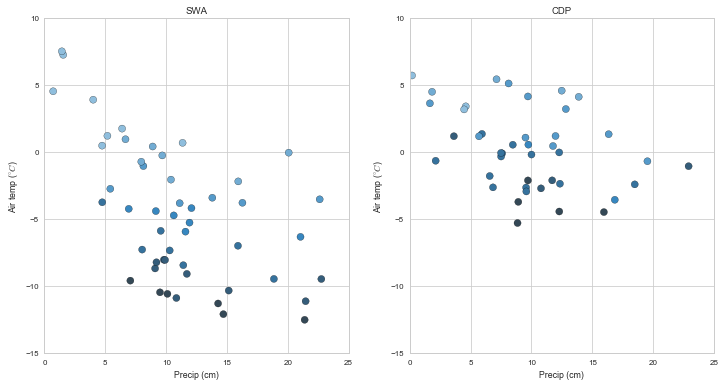

In [55]:
my_cmap = matplotlib.colors.ListedColormap(sns.color_palette('Blues_d', 7).as_hex())
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for n, s in enumerate(siteNames):
    ax = axes[n]
    ax.scatter(force_monthly[s].precipSnow * 100, force_monthly[s].Tair, s=50,
                c=force_monthly[s].snowTs, cmap=my_cmap)
    ax.set_ylabel('Air temp ($^{\circ}C$)')
    ax.set_xlabel('Precip (cm)')
    ax.set_title(s)
    ax.set_ylim(-15, 10)
    ax.set_xlim(0, 25)

In [56]:
results_monthly = {'SWA': SWA.resample(how='mean', dim='time', freq='M'),
                   'CDP': CDP.resample(how='mean', dim='time', freq='M')} 

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive


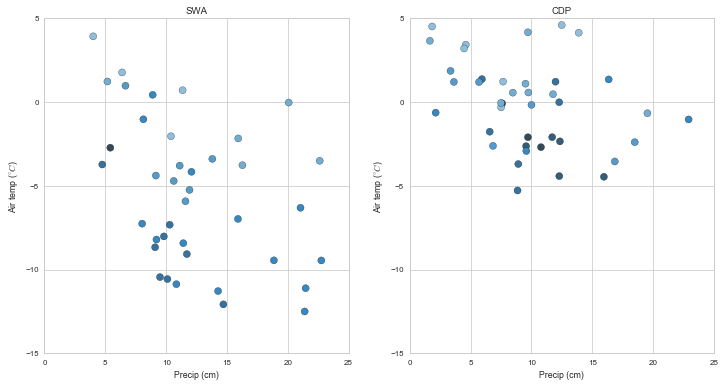

In [97]:
flag_modelRelative = True
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
my_cmap = matplotlib.colors.ListedColormap(sns.color_palette('Blues_d', 7).as_hex())

for n, s in enumerate(siteNames):

    # Bias relative to model with no errors
    if flag_modelRelative:
        noBias = results_monthly[s].sel(expID='jrdn1991')
        ds = ((results_monthly[s].scalarSnowTemp) - noBias.scalarSnowTemp)
        ds = ds.where((results[s].scalarSWE > 0) & (noBias.scalarSWE > 0))
    # Bias relative to observations
    else:
        ds = ((results_monthly[s].scalarSnowTemp - 273.15) - force_monthly[s].snowTs)
        ds = ds.where((force[s].SP) & (results[s].scalarSWE > 0))

    ax = axes[n]
    c = ds.sel(expID='lowLW_L')
    ax.scatter(force_monthly[s].precipSnow * 100, force_monthly[s].Tair, s=50,
                c=c.values, cmap=my_cmap)
    ax.set_ylabel('Air temp ($^{\circ}C$)')
    ax.set_xlabel('Precip (cm)')
    ax.set_title(s)
    ax.set_ylim(-15, 5)
    ax.set_xlim(0, 25)

Snow depth instead of snow precip

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive


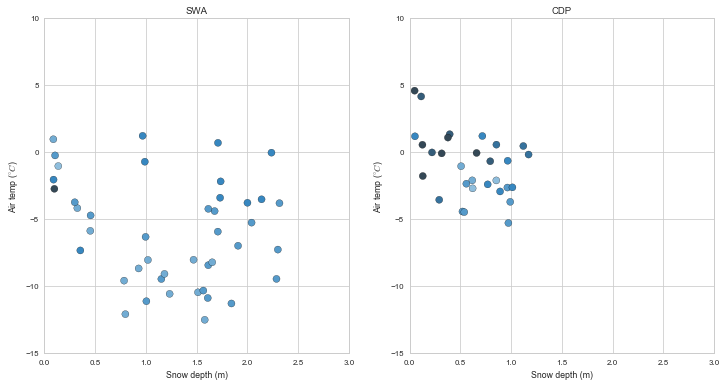

In [95]:
flag_modelRelative = True
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
my_cmap = matplotlib.colors.ListedColormap(sns.color_palette('Blues_d', 7).as_hex())

for n, s in enumerate(siteNames):
    # Bias relative to model with no errors
    if flag_modelRelative:
        noBias = results_monthly[s].sel(expID='jrdn1991')
        ds = ((results_monthly[s].scalarSnowTemp) - noBias.scalarSnowTemp)
        ds = ds.where((results[s].scalarSWE > 0) & (noBias.scalarSWE > 0))
    # Bias relative to observations
    else:
        ds = ((results_monthly[s].scalarSnowTemp - 273.15) - force_monthly[s].snowTs)
        ds = ds.where((force[s].SP) & (results[s].scalarSWE > 0))

    ax = axes[n]
    c = ds.sel(expID='highLW_L')
    ax.scatter(force_monthly[s].snowDepth, force_monthly[s].Tair, s=50,
                c=c.values, cmap=my_cmap)
    ax.set_ylabel('Air temp ($^{\circ}C$)')
    ax.set_xlabel('Snow depth (m)')
    ax.set_title(s)
    ax.set_ylim(-15, 10)
    ax.set_xlim(0, 3)

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive


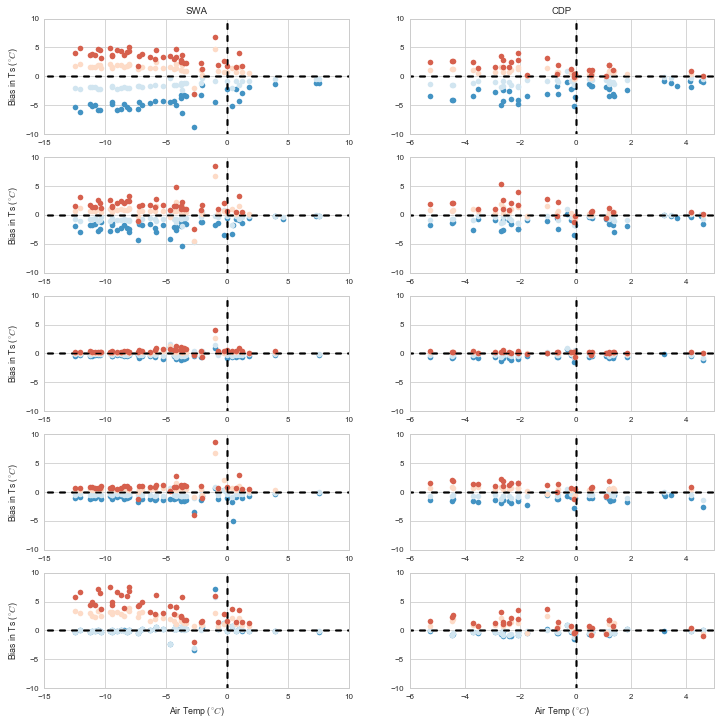

In [94]:
flag_modelRelative = True
fig, axes = plt.subplots(5, 2, figsize=(12, 12))
my_cmap = matplotlib.colors.ListedColormap(sns.color_palette('Blues_d', 7).as_hex())

for n, s in enumerate(siteNames):
    # Bias relative to model with no errors
    if flag_modelRelative:
        noBias = results_monthly[s].sel(expID='jrdn1991')
        ds = ((results_monthly[s].scalarSnowTemp) - noBias.scalarSnowTemp)
        ds = ds.where((results[s].scalarSWE > 0) & (noBias.scalarSWE > 0))
    # Bias relative to observations
    else:
        ds = ((results_monthly[s].scalarSnowTemp - 273.15) - force_monthly[s].snowTs)
        ds = ds.where((force[s].SP) & (results[s].scalarSWE > 0))
        
    for expNum, exp in enumerate(expMetUnc):
        for nameNum, names in enumerate(sorted(expNames[exp], key=sortFun)):
            ax = axes[expNum, n]
            c = ds.sel(expID=names)
            ax.plot(force_monthly[s].Tair, c.values, 'o', color=sns.color_palette('RdBu_r', 4)[nameNum])
            ax.plot([0, 0], [-25, 25], 'k--')
            ax.plot([-25, 25], [0, 0], 'k--')
            
            if ax.is_first_col():
                ax.set_ylabel('Bias in Ts ($^{\circ}C$)')
            if ax.is_last_row():
                ax.set_xlabel('Air Temp ($^{\circ}C$)')
            if ax.is_first_row():
                ax.set_title(s)
            if s == 'SWA':
                ax.set_xlim(-15, 10)
            elif s == 'CDP':
                ax.set_xlim(-6, 5)
            ax.set_ylim(-10, 10)

In [81]:
met

['longwaveBias', 'shortwaveBias', 'specHumidBias', 'airTempBias', 'windBias']

## Model output

In [85]:
diffSWE = CDP.scalarSWE.diff(dim='time')
melt = diffSWE.where(diffSWE < 0)
CDP['melt'] = melt.reindex_like(CDP)
CDP['meltDaily'] = CDP.melt.resample(how='mean', dim='time', freq='d').reindex_like(CDP.time, method='ffill')

diffSWE = SWA.scalarSWE.diff(dim='time')
melt = diffSWE.where(diffSWE < 0)
SWA['melt'] = melt.reindex_like(SWA)
SWA['meltDaily'] = SWA.melt.resample(how='mean', dim='time', freq='d').reindex_like(SWA.time, method='ffill')


//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive
